In [14]:
import numpy as np
import pandas as pd

data = pd.read_csv('incident_event_log.csv')

In [ ]:
data.head()
# Le dataset contient 36 colonnes et 141 712 lignes

In [ ]:
data.contact_type.value_counts()
# Chaque entrée correspond à la mise à jour du statut d'un ticket

In [ ]:
data.incident_state.value_counts()
# Que signifie -100 ?

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
data[data['number'] == 'INC0000102']

In [ ]:
# Les colonnes suivantes seront lâchées :
# 
data.contact_type.value_counts()

### Nous allons convertir les colonnes de date en datetime (ce sont des objets à l'import) et calculer le temps avant résolution pour chaque ticket résolu

In [15]:
# Fonction qui renvoie le nombre de secondes correspondant à un intervalle de datetime
def get_seconds(timedelta):
    return timedelta.total_seconds()

# Fonction qui convertit les strings de date en datetime et ajoute une colonne
# contenant la durée de vie, en secondes, d'un ticket avec résolution
def compute_delta(df):   
    df = df[df['resolved_at'] != '?']
    df.resolved_at = pd.to_datetime(df['resolved_at'], format='%d/%m/%Y %H:%M')
    df.opened_at = pd.to_datetime(df['opened_at'], format='%d/%m/%Y %H:%M')
    df['delta'] = df.resolved_at - df.opened_at
    df['delta'] = df['delta'].apply(get_seconds)
    df.drop(['resolved_at', 'opened_at', 'closed_at'], axis='columns', inplace=True)
    return df

In [16]:
m_set = data.copy(deep=False)
m_set = compute_delta(m_set)

C:\Users\jamaica\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\jamaica\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\jamaica\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### On transorme toutes les données non numériques en données numériques (sauf pour les booléens qui sont bien gérés par scikit-learn)

In [17]:
# Fonction qui transforme la colonne priorité du dataframe afin de n'avoir que des valeurs numériques
def priority_to_int(df):
    df['priority'] = df['priority'].astype('category')
    df['priority'] = df['priority'].cat.reorder_categories(['1 - Critical', '2 - High', '3 - Moderate', '4 - Low'], ordered=True)
    df['priority'] = df['priority'].cat.codes
    df.drop(['impact', 'urgency'], axis='columns', inplace=True)
    return df

In [18]:
m_set = priority_to_int(m_set)

In [19]:
notify_dict = {
    'Do Not Notify': 0,
    'Send Email': 1
}
m_set['notify'] = m_set['notify'].map(notify_dict)

In [ ]:
#m_set[m_set['vendor'] == '?'] # -> drop [NA: 141 468 / 141 712]
#m_set[m_set['cmdb_ci'] == '?'] # -> drop [NA: 141 267 / 141 712]
#m_set[m_set['problem_id'] == '?'] # -> drop [NA: 139 417 / 141 712]
#m_set[m_set['rfc'] == '?'] # -> drop [NA: 140 721 / 141 712]
#m_set[m_set['caused_by'] == '?'] # -> drop [NA: 141 689 / 141 712]
#m_set[m_set['closed_code'] == '?']

In [20]:
# On remarque que les colonnes sys_created_at et sys_created_by sont fortement liées. Si l'une est renseignée, alors l'autre le sera. 
# Il manque plus d'un tiers des valeurs et puisque nous cherchons à calculer le temps de résolution d'un ticket et non pas vraiment sa durée de vie, 
# l'information donnée par opened_at devrait être suffisante. Ces deux colonnes ne serviront pas pour la régression
# Les colonnes sys_updated_[by/at] seront également drop
m_set.drop(['vendor', 'cmdb_ci', 'problem_id', 'rfc', 'caused_by', 'sys_created_at', 'sys_created_by', 'sys_updated_at', 'sys_updated_by', 'opened_by'], axis='columns', inplace=True)

In [ ]:
m_set.incident_state.value_counts()

In [ ]:
# Tentative de développer une fonction permettant de calculer
# la durée pendant laquelle un ticket était en attente.

#def compute_awaiting_time(data):
#ar = test.number.unique()
#for e in ar:
#    indices = test[test['number'] == e]
#    awaiting = indices[indices['incident_state'] == 'Awaiting User Info']
#    if not awaiting.empty:
#        print(awaiting.iloc[0])
#blabla = pd.DataFrame()

In [21]:
m_set = m_set[m_set['incident_state'] == 'Closed']

## Data Vizualisation

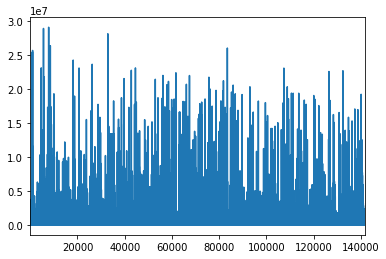

In [267]:
import matplotlib.pyplot as plt
import seaborn

m_set['delta'].plot()

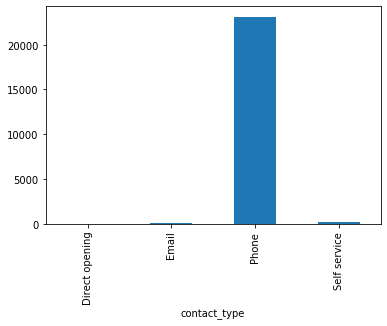

In [243]:
m_set.groupby('contact_type')['number'].nunique().plot(kind='bar')

In [47]:
m_set.groupby('contact_type')['delta'].mean().plot(kind="bar")
# On voit que 99% des contacts ont été effectués par téléphone
# Les tickets ayant la plus longue durée avant résolution sont ceux
# pour lesquels le premier contact a été effectué au self-service
# J'ai initialement pensé supprimer la colonne puisque ces données ne sont que très peu variables 

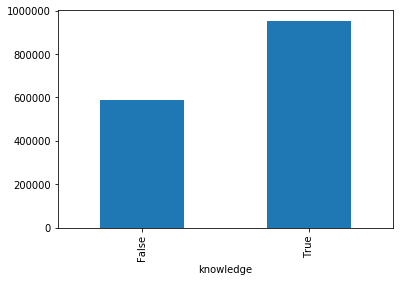

In [48]:
#m_set.groupby('category')['delta'].mean().plot(kind="bar")
#m_set.groupby('reassignment_count')['delta'].mean().plot(kind="bar")
m_set.groupby('knowledge')['delta'].mean().plot(kind="bar")

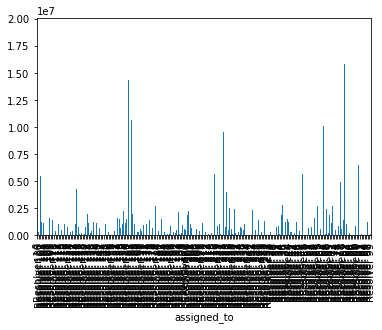

In [50]:
m_set.groupby('assigned_to')['delta'].mean().plot(kind="bar")
# m_set.groupby('notify')['delta'].mean().plot(kind="bar")

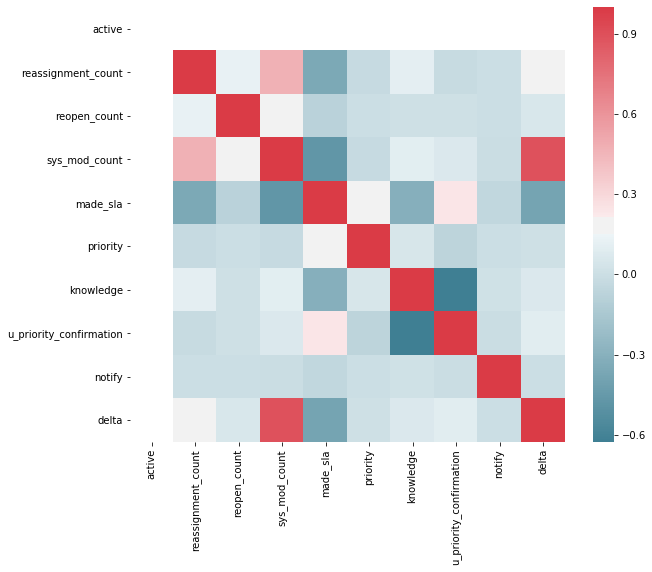

In [244]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = m_set.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [ ]:
m_set.contact_type.value_counts()
#m_set.drop(['contact_type'], axis='columns', inplace=True)

## Modèles

In [ ]:
m_set.info()

In [22]:
# Nous allons encoder les données de type "object" (les strings) afin qu'elles puissent être gérées par la suite par les modèles
#onehottest = pd.get_dummies(m_set, columns=['caller_id', 'location', 'category', 'u_symptom', 'assignment_group', 'assigned_to', 'closed_code', 'resolved_by'])
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

letest = m_set.copy(deep=False)
letest['caller_id'] = le.fit_transform(letest['caller_id'])
letest['location'] = le.fit_transform(letest['location'])
letest['category'] = le.fit_transform(letest['category'])
letest['u_symptom'] = le.fit_transform(letest['u_symptom'])
letest['assignment_group'] = le.fit_transform(letest['assignment_group'])
letest['assigned_to'] = le.fit_transform(letest['assigned_to'])
letest['closed_code'] = le.fit_transform(letest['closed_code'])
letest['resolved_by'] = le.fit_transform(letest['resolved_by'])
letest = pd.get_dummies(letest, columns=['contact_type'])

### Premier modèle : Régression linéaire

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

y = letest['delta']
X = letest.drop(['delta', 'number', 'incident_state', 'subcategory'], axis=1)
#X = m_set.drop(['delta', 'number', 'incident_state', 'assignment_group', 'assigned_to', 'caller_id', 'location', 'opened_by', 'category', 'subcategory', 'closed_code', 'resolved_by', 'u_symptom'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [259]:
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
score

0.8635081059852676

### Deuxième modèle : Random Forest Regressor

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
params = { 
            "n_estimators"      : [10, 20, 30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2, 4, 8],
            "bootstrap": [True, False],
         }

model_2 = GridSearchCV(rfr, params, n_jobs = -1, cv = 5)
model_2.fit(X_train, y_train)

C:\Users\jamaica\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 4, 8], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
model_2.score(X_test, y_test)

0.9102886787138381

In [33]:
model_2.best_estimator_.feature_importances_
print(sorted(zip(map(lambda x: round(x, 4), model_2.best_estimator_.feature_importances_), X_test.columns), reverse=True))

[(0.879, 'sys_mod_count'), (0.0325, 'made_sla'), (0.0299, 'reassignment_count'), (0.0088, 'reopen_count'), (0.0086, 'u_priority_confirmation'), (0.0059, 'caller_id'), (0.0058, 'assigned_to'), (0.0052, 'assignment_group'), (0.0044, 'location'), (0.0041, 'resolved_by'), (0.0038, 'category'), (0.0037, 'closed_code'), (0.003, 'u_symptom'), (0.003, 'priority'), (0.0022, 'knowledge'), (0.0001, 'contact_type_Self service'), (0.0001, 'contact_type_Phone'), (0.0, 'notify'), (0.0, 'contact_type_Email'), (0.0, 'contact_type_Direct opening'), (0.0, 'active')]


In [45]:
# On crée un nouveau modèle en utilisant uniquement les 3 variables les plus importantes
# Simplifiera l'utilisation de l'API Django

X_train_bis = X_train[['sys_mod_count', 'made_sla', 'reassignment_count']]
model_bis = GridSearchCV(rfr, params, n_jobs = -1, cv = 5)
model_bis.fit(X_train_bis, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 30], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 4, 8], 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
import os
import pickle

path = 'django_api/models/random_forest_regressor'
with open(path, 'wb') as file:
    pickle.dump(model_bis, file)

### Troisième modèle : XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model_3 = XGBClassifier()
model_3.fit(X_train, y_train)

predictions = model_3.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))